In [1]:
# caveat: I removed wrapping views in ACEtk to make ENDFtk and ACEtk work together
import ENDFtk
import ACEtk
import scion

import matplotlib.pyplot as plot
%matplotlib notebook

In [2]:
# the files we want to look at
endf80file = '../performance/Li6-endf80.endf'
endf81b11file = '../performance/Li6-endf81-beta1.1.endf'
acefile = '/Users/ftuser/Desktop/Lib80x/Lib80x/Li/3006.800nc'

In [3]:
# open the ENDF and ACE file
tape = ENDFtk.tree.Tape.from_file( endf80file )
endf80 = tape.materials.front().parse()
tape = ENDFtk.tree.Tape.from_file( endf81b11file )
endf81b11 = tape.materials.front().parse()
ace80 = ACEtk.ContinuousEnergyTable.from_file( acefile )

In [4]:
# convert to the proper Legendre coefficients
def convert( coefficients ) :
    
    converted = [ 0.5 ]
    for i in range( 1, len( coefficients ) + 1 ) :
        
        converted.append( ( 2 * i + 1 ) / 2 * coefficients[i - 1] )
    
    return converted

In [5]:
# retrieve the ENDF data for 15 MeV
endf_elastic80 = endf80.file( 4 ).section( 2 ).distributions
endf_elastic81b11 = endf81b11.file( 4 ).section( 2 ).distributions

index80 = -16
index81b11 = -13

endf80_legendre = scion.math.LegendreSeries( convert( endf_elastic80.angular_distributions[index80].coefficients ) )
endf81b11_legendre = scion.math.LegendreSeries( convert( endf_elastic81b11.angular_distributions[index81b11].coefficients ) )

print( 'order: ', endf80_legendre.order )
print( 'order: ', endf81b11_legendre.order )

order:  6
order:  6


In [6]:
ace_elastic = ace80.angular_distribution_block.angular_distribution_data(0)

index = -16

incident_energy = ace_elastic.incident_energies[index]
ace_legendre = ace_elastic.distributions[index]

<IPython.core.display.Javascript object>


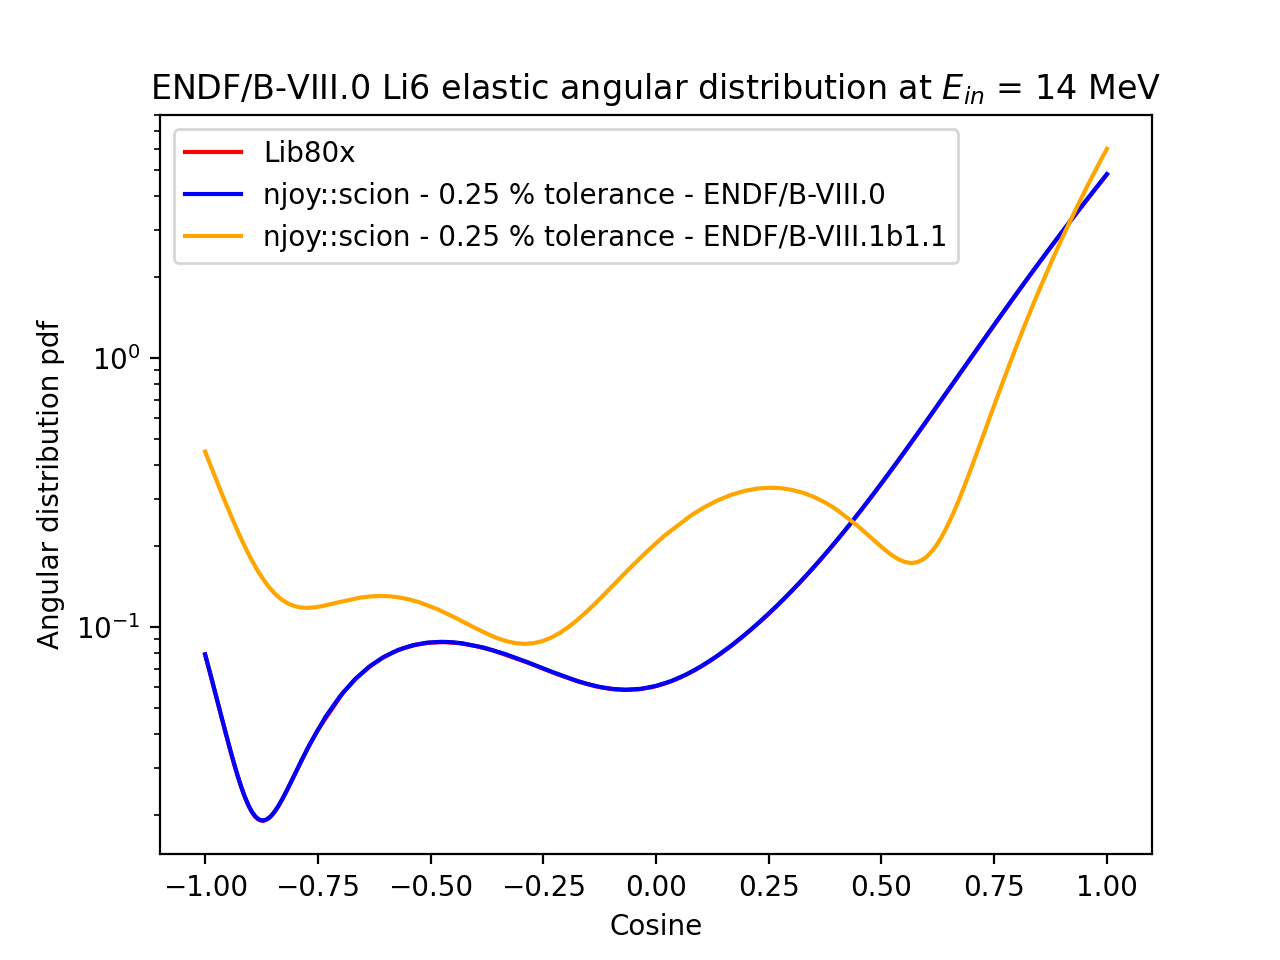

In [14]:
# linearise the pdf at different tolerances
plot1 = endf80_legendre.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf81b11_legendre.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )

# plot the data
plot.figure()
plot.plot( ace_legendre.cosines, ace_legendre.pdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'njoy::scion - 0.25 % tolerance - ENDF/B-VIII.0', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'njoy::scion - 0.25 % tolerance - ENDF/B-VIII.1b1.1', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 Li6 elastic angular distribution at $E_{in}$ = 14 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()
plot.savefig('test.png')

In [8]:
print( len( ace_legendre.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

92
103
120


<IPython.core.display.Javascript object>


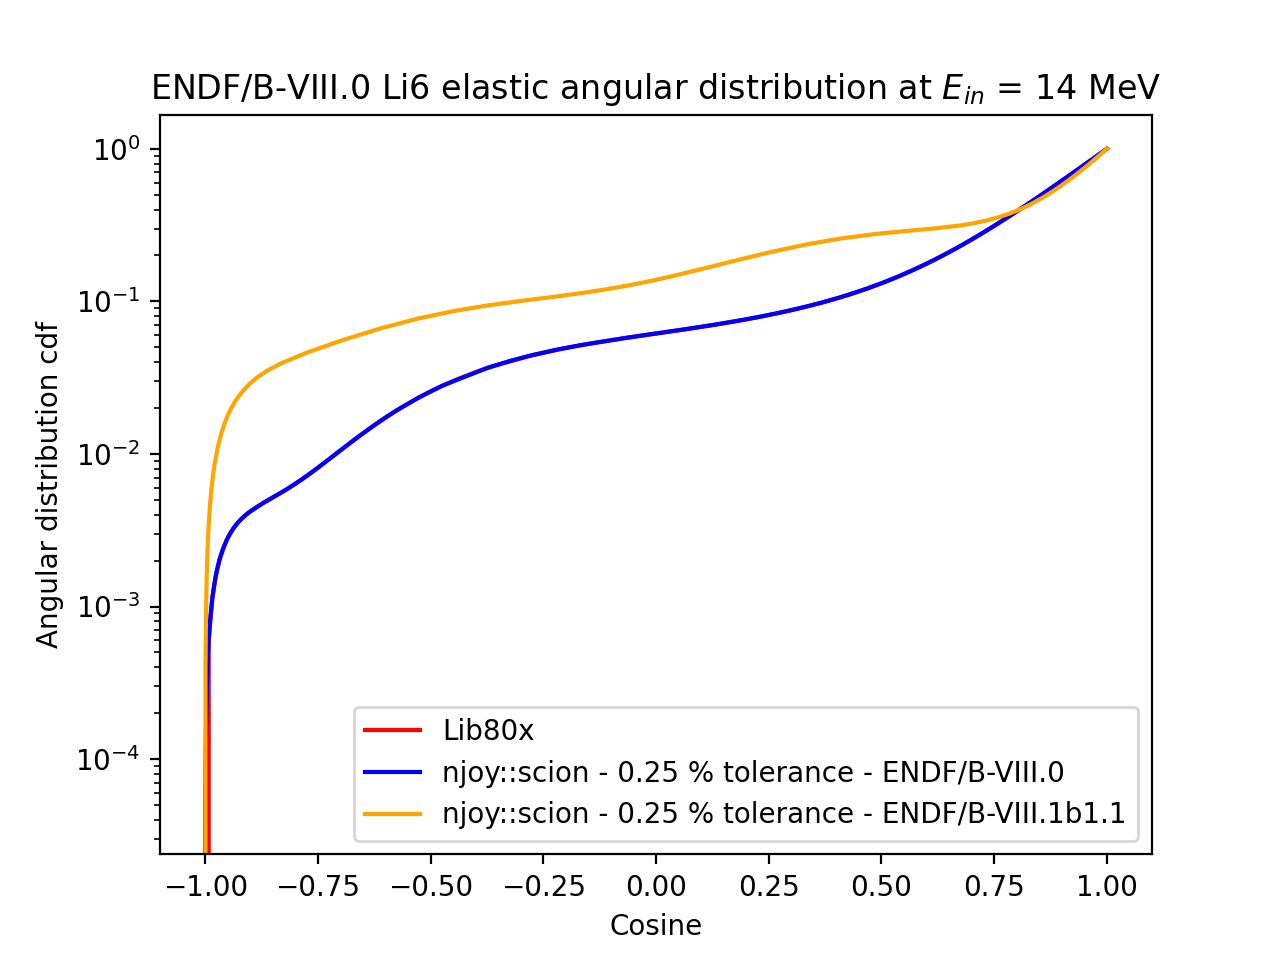

In [15]:
# we can linearise the cdf directly based on the primitive of the pdf as a Legendre series
endf80_cdf = endf80_legendre.primitive( -1.0 ) # the integral[-1,x] of the endf_legendre series
endf81b11_cdf = endf81b11_legendre.primitive( -1.0 ) # the integral[-1,x] of the endf_legendre series

plot1 = endf80_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf81b11_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )

# plot the data
plot.figure()
plot.plot( ace_legendre.cosines, ace_legendre.cdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'njoy::scion - 0.25 % tolerance - ENDF/B-VIII.0', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'njoy::scion - 0.25 % tolerance - ENDF/B-VIII.1b1.1', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution cdf' )
plot.title( 'ENDF/B-VIII.0 Li6 elastic angular distribution at $E_{in}$ = 14 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

In [10]:
# fun fact: the cdf is a lot smoother than the pdf so we need a lot less points to represent it as the pdf
# at the same tolerances
print( len( ace_legendre.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

92
84
66


In [11]:
# we can verify that the pdf never goes below zero in [-1,1] by calculating the roots of the pdf on the real axis
print( 'roots: ', endf80_legendre.roots() )
print( 'roots: ', endf81b11_legendre.roots() )

roots:  []
roots:  []


In [12]:
# we can verify that the cdf is monotonically increasing in [-1,1] by calculating the roots of the 
# first derivative of the cdf on the real axis and showing that the derivative is always above zero
# and yes: I know that boils down to calculating the roots of the pdf but I'm flexing the interface here :-)
print( 'roots: ', endf80_legendre.primitive( -1 ).derivative().roots() )
print( 'roots: ', endf81b11_legendre.primitive( -1 ).derivative().roots() )

roots:  []
roots:  []
